#  Hidden Markov Gaussian Mixture model

### BS. Lê Ngọc Khả Nhi


# Giới thiệu

Trong bài trước, Nhi đã giới thiệu với các bạn về mô hình Hidden Markov Gaussian Emission (HMMG) nhằm xác định quy luật chuyển tiếp giữa các trạng thái nối tiếp trên chuỗi dữ liệu định lượng. 
Nếu các bạn chưa đọc qua bài này có thể xem lại tại đây:
Lần đó, chúng ta chỉ mới áp dụng mô hình HMMG cho một (biến) dữ liệu chuỗi duy nhất. Hôm nay, chúng ta sẽ giải quyết một bài toán phức tạp hơn, đó là khảo sát đồng thời 2 chuỗi dữ liệu bằng mô hình HMMG. Bài toán này tương đương với một phân phối Gaussian hỗn hợp, gồm 2 chiều không gian và chiều thứ 3 là thời gian.

Như lần trước, chúng ta sẽ làm việc trên dataset theo dõi SpO2 trong thời gian nằm viện của những bệnh nhân nhiễm Covid-19. Lần này dữ liệu của Nhi tăng lên đến 81 bệnh nhân, hơn nữa ngoài SpO2 Nhi còn có thêm 1 thông số là lưu lượng khí Oxy cung cấp cho bệnh nhân, mà Nhi sẽ chuyển đổi thành đại lượng vật lý là FiO2, phân suất Oxy trong khí hít vào (Một số bệnh nhân bị suy hô hấp được cho hít khí Oxy 100% qua catheter mũi).

Như vậy cho mỗi bệnh nhân ta sẽ có 2 chuỗi dữ liệu SpO2 và FiO2. Mục tiêu là xác định quy luật chuyển tiếp giữa các trạng thái lâm sàng (chưa rõ) bằng mô hình HMMG.

In [1]:
# Công cụ

from functools import lru_cache

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow_probability as tfp

# Đồ họa

import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import cm

import seaborn as sns

# network
import networkx as nx
from graphviz import Source

# HMMG
from hmmlearn.hmm import GaussianHMM

# Bước 1:

Như lần trước, dữ liệu gốc có dạng bảng dọc (Long table format), trong đó mỗi bệnh nhân được mã hóa bằng 1 chuỗi string (cột Patient), và liên kết với 2 chuỗi: Flow = Lưu lượng oxy cung cấp; và SpO2. Trình tự của chuỗi bị đảo ngược (từ ngày cuối ngược dần về ngày đầu nhập viện).

Đầu tiên Nhi dùng 1 recursive function để tính FiO2 từ Flow;

Sau đó Nhi tạo ra 1 database dạng dictionary, trong đó keys = tên mỗi bệnh nhân, tương ứng với value = 1 dictionnary gồm 2 arrays: 1 ghi giá trị SpO2 và 1 ghi FiO2; theo trình tự thời gian xuôi (nhập viện-xuát viện).

In [3]:
# Hàm tính FiO2 từ Oxygen flow

@lru_cache(maxsize = None)
def fio2_cal(flow):
    if flow <= 3:
        return flow*4 + 21
    return(fio2_cal(flow - 1) + 3)

def database_gen(path = 'HMMCovidJB.csv',
                cols = ['Patient','Time','Flow','SpO2'],
                ):
    
    df = pd.read_csv(path, sep =';')[cols].dropna(how = 'any', axis = 0)
    df['Time'] = pd.to_datetime(df['Time'])
    df['Patient'] = [p.strip() for p in df['Patient']]
    
    df['FiO2'] = np.array([fio2_cal(flow) for flow in df['Flow']])
    
    patients = np.unique(df['Patient'])
    seq_db = dict.fromkeys(patients)
    target = ['SpO2','FiO2']
    
    for p in patients:
        seq_dict = dict.fromkeys(target)
        for t in target:
            seq_dict[t] = np.array(df[df['Patient'] == p][t].iloc[::-1])
            
        seq_db[p] = seq_dict
        
    return df, seq_db

In [4]:
df, seq_db = database_gen()

In [11]:
df[df['Patient'] == 'DEPE_0705']

,Patient,Time,Flow,SpO2,FiO2
1054,DEPE_0705,2020-07-05 08:00:00,0.0,98.0,21.0
1055,DEPE_0705,2020-07-05 05:00:00,0.0,97.0,21.0
1056,DEPE_0705,2020-06-05 22:00:00,0.0,98.0,21.0
1057,DEPE_0705,2020-06-05 20:00:00,0.0,95.0,21.0
1058,DEPE_0705,2020-06-05 16:00:00,0.0,98.0,21.0
...,...,...,...,...,...
1183,DEPE_0705,2020-09-04 00:00:00,2.0,98.0,29.0
1184,DEPE_0705,2020-08-04 22:00:00,2.0,95.0,29.0
1185,DEPE_0705,2020-08-04 16:00:00,2.0,95.0,29.0
1186,DEPE_0705,2020-08-04 12:00:00,0.0,95.0,21.0


In [13]:
seq_db['DEPE_0705']

{'SpO2': array([99., 95., 95., 95., 98., 92., 94., 90., 92., 95., 95., 99., 88.,
        94., 90., 96., 94., 96., 98., 97., 95., 91., 86., 96., 98., 94.,
        97., 90., 96., 94., 94., 97., 96., 96., 94., 96., 99., 94., 95.,
        94., 95., 95., 96., 95., 95., 94., 96., 95., 96., 97., 96., 97.,
        96., 97., 97., 96., 97., 97., 98., 98., 96., 98., 96., 99., 96.,
        94., 95., 97., 97., 97., 96., 98., 97., 95., 98., 97., 94., 96.,
        98., 99., 97., 96., 99., 99., 99., 97., 98., 97., 97., 97., 98.,
        97., 99., 98., 95., 96., 94., 97., 94., 98., 98., 99., 97., 99.,
        95., 99., 97., 98., 98., 98., 99., 98., 98., 99., 97., 97., 96.,
        94., 96., 97., 99., 95., 99., 99., 98., 92., 93., 94., 98., 95.,
        98., 97., 98.]),
 'FiO2': array([29., 21., 29., 29., 29., 29., 29., 21., 21., 21., 21., 21., 21.,
        25., 29., 25., 25., 25., 25., 25., 25., 25., 27., 27., 21., 25.,
        27., 27., 27., 29., 29., 29., 27., 27., 27., 27., 29., 21., 21.,
        21

Có 81 bệnh nhân, tên được mã hóa trong danh sách names; 

Để chuẩn bị cho việc dựng mô hình, Nhi chuẩn bị 1 object lengths lưu độ dài của chuỗi SpO2/FiO2 cho mỗi bệnh nhân.

In [42]:
names = seq_db.keys()

In [236]:
len(names)

81

In [45]:
lengths = [len(seq_db[p]['SpO2']) for p in seq_db.keys()]

In [46]:
for i,j in zip(names, lengths):
    print(i, j)

ALCA_2603 61
BABE_1804 22
BAPA_0705 66
BETA_0204 14
BIJU_0405 80
CACH_0505 76
CAJO_2104 122
CEGE_3004 108
CHBE_2403 20
CHCL_0904 10
CHLU_1604 18
COMA_2404 99
DACL_1704 30
DEDAN_2504 58
DEFR_1704 45
DEJO_1704 47
DEPE_0705 133
DHAN_1305 93
DHRA_2304 112
DIBEVI_2303 16
DINOAL_1704 14
DOAN_2204 44
DRER_1304 30
DUFR_1404 71
DUJE_0504 48
ERLY_2804 58
FICH_0804 18
FONI_0304 80
FRJO_0604 22
GETH_1304 29
GIMA_3003 19
GIOAN_3004 111
GOFR_3003 30
GOPE_2304 22
GRMO_2204 54
GUCH_0204 40
HALI_0905 147
HEAN_3003 43
HUJA_1404 53
IGMI_0405 67
JOJEN_0804 30
JORI_0604 19
KACH_0705 65
KHSA_0605 34
LAJA_3103 42
LALA_1004 51
LAMA_2204 76
LILU_1004 77
MAEL_2703 32
MANA_2503 22
MAVI_0104 22
MOAN_2704 107
MOCH_2503 18
MTPES_0705 56
MUDO_2003 27
NICL_2504 37
NIMI_3003 13
NONAME 24
NONE_3004 46
PAJO_0505 115
PHJA_1004 64
PIMI_2604 48
POGA_0704 24
POMAAN_0504 22
POYV_0504 59
QUJU_2204 31
ROFLO_0804 54
ROGIO_2704 118
ROMA_1904 146
ROPA_1904 47
RUBE_1704 18
RURO_0104 26
SCJE_1004 87
SEJE_0704 17
STAM_0704 25
STBI_2

# Bước 2: Thăm dò trực quan dữ liệu

Nhi viết 1 hàm plot_sequence cho phép hiển thị song song 2 chuỗi SpO2 (màu đỏ) và FiO2 (màu xanh) cho một bệnh nhân bất kì.

Trên biểu đồ, lưu ý 2 đường thẳng màu đen chỉ ngưỡng an toàn của SpO2 (93) và Ngưỡng FiO2 khí quyển (21). Khi SpO2 thấp hơn 93% là dấu hiệu suy hô hấp, khi FiO2 cao hơn 21% tức là bắt đầu áp dụng Oxy trị liệu.

Nhi thử khảo sát dữ liệu thô của vài bệnh nhân...

In [49]:
def plot_sequence(seq_db = seq_db, patient = 'DEPE_0705'):
    spo2 = seq_db[patient]['SpO2']
    fio2 = seq_db[patient]['FiO2']
    
    plt.rcParams.update({'font.size': 16})
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,8), dpi = 100)
    
    axs[0].set_title(f'Chuỗi dữ liệu của bệnh nhân {patient}')
    
    axs[0].fill_between(np.arange(spo2.shape[0]),
                        np.repeat(np.min(spo2)-2, spo2.shape[0]),
                        spo2, 
                        step="pre",
                        color = 'red',
                        alpha=0.3)
    
    axs[0].hlines(y = 93, xmin = 0, xmax = spo2.shape[0],
                 linestyles= 'dashed')
    
    axs[0].set_ylabel('SpO2')
    
    axs[0].plot(np.arange(spo2.shape[0]),
                spo2,
                drawstyle="steps", 
                alpha = 0.4,
                color = 'red')
        
    axs[1].fill_between(np.arange(fio2.shape[0]),
                        np.repeat(np.min(fio2)-2, fio2.shape[0]),
                        fio2, 
                        step="pre",
                        alpha=0.3,
                        color ='blue')
    
    axs[1].set_xlabel('Time points')
    axs[1].set_ylabel('FiO2')
    
    axs[1].plot(np.arange(fio2.shape[0]),
                fio2,
                drawstyle="steps", 
                color = 'blue',
                alpha = 0.4)
    
    axs[1].hlines(y = 21, xmin = 0, xmax = fio2.shape[0],
                 linestyles= 'dashed')

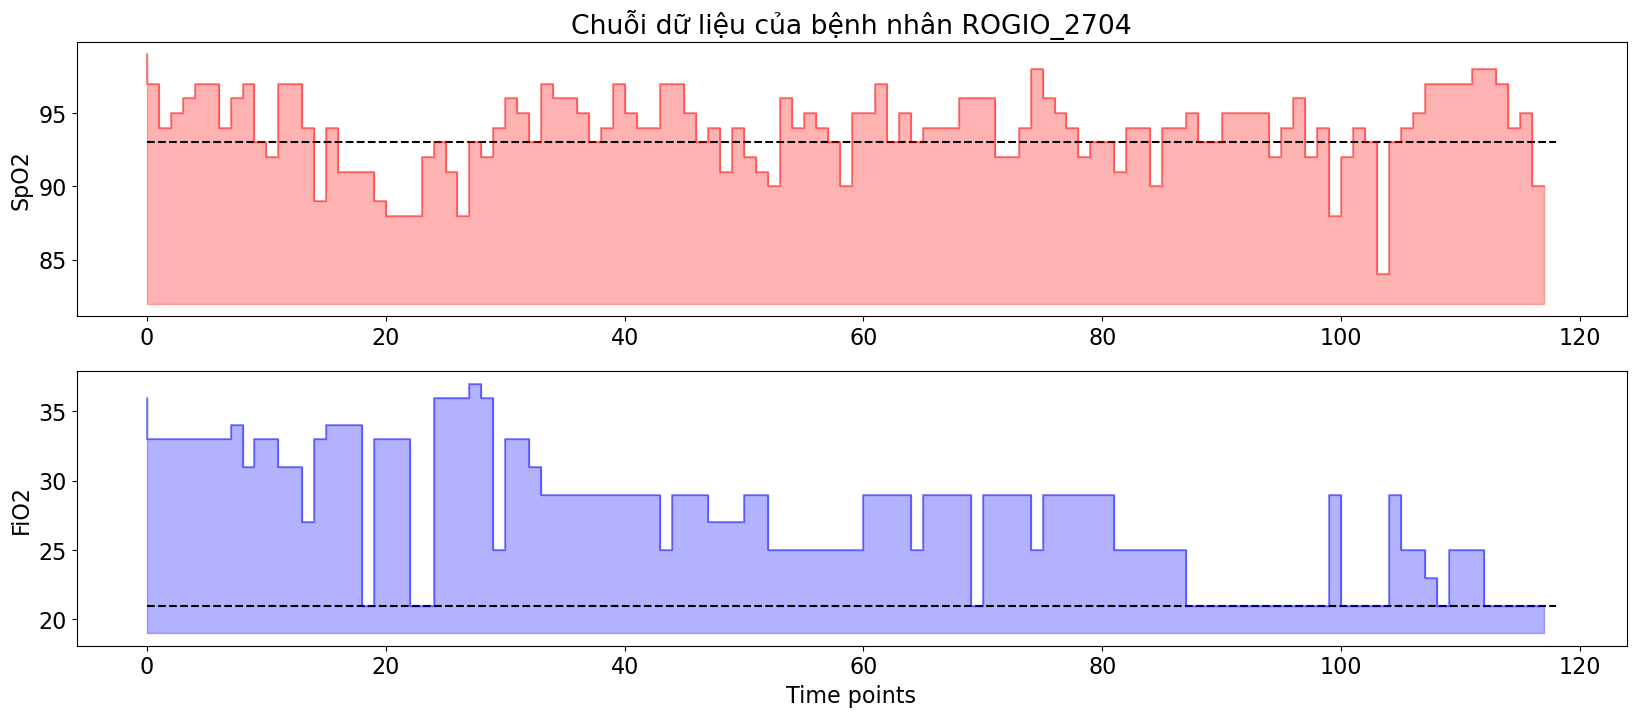

In [50]:
plot_sequence(seq_db, patient = 'ROGIO_2704')

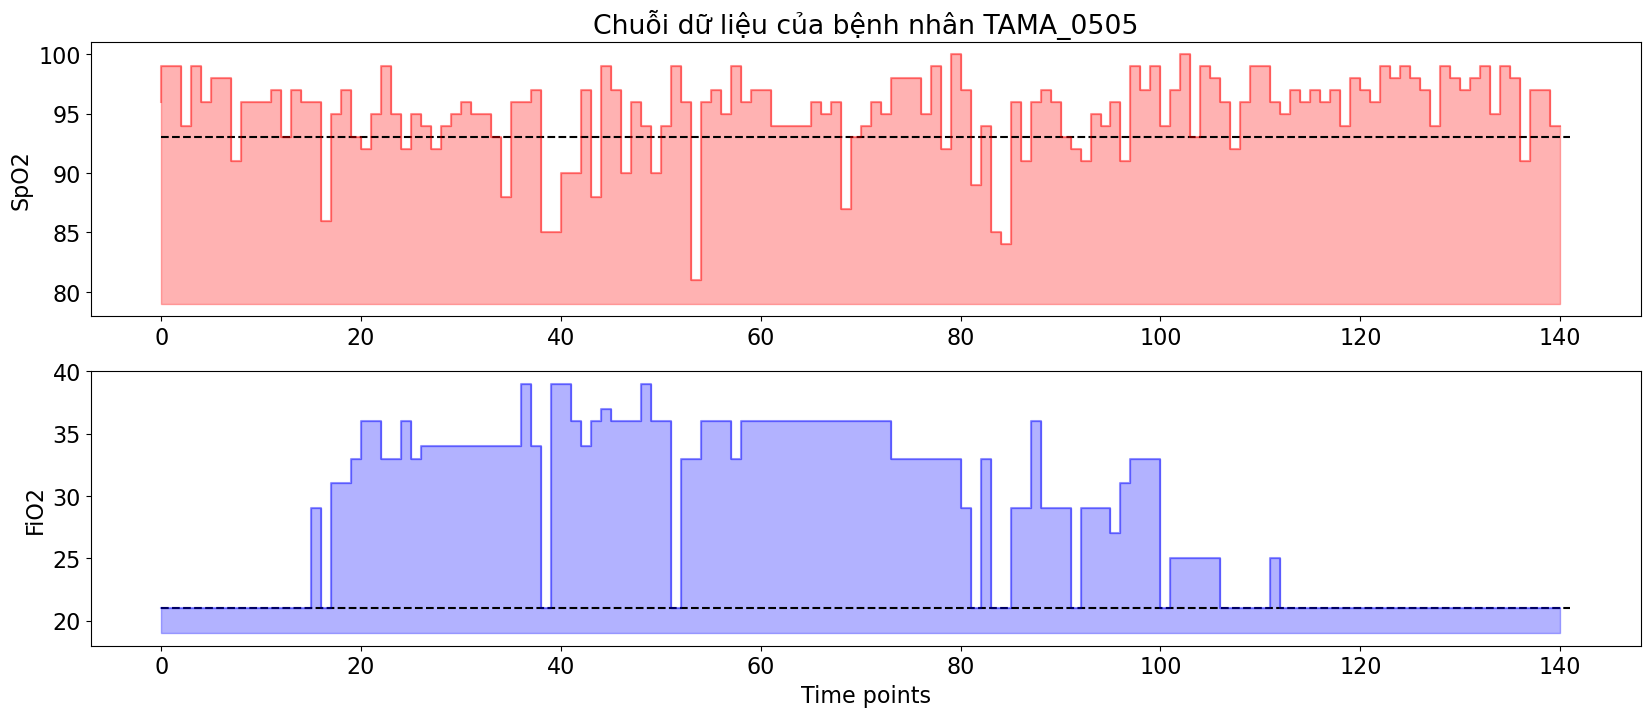

In [51]:
plot_sequence(seq_db, patient = 'TAMA_0505')

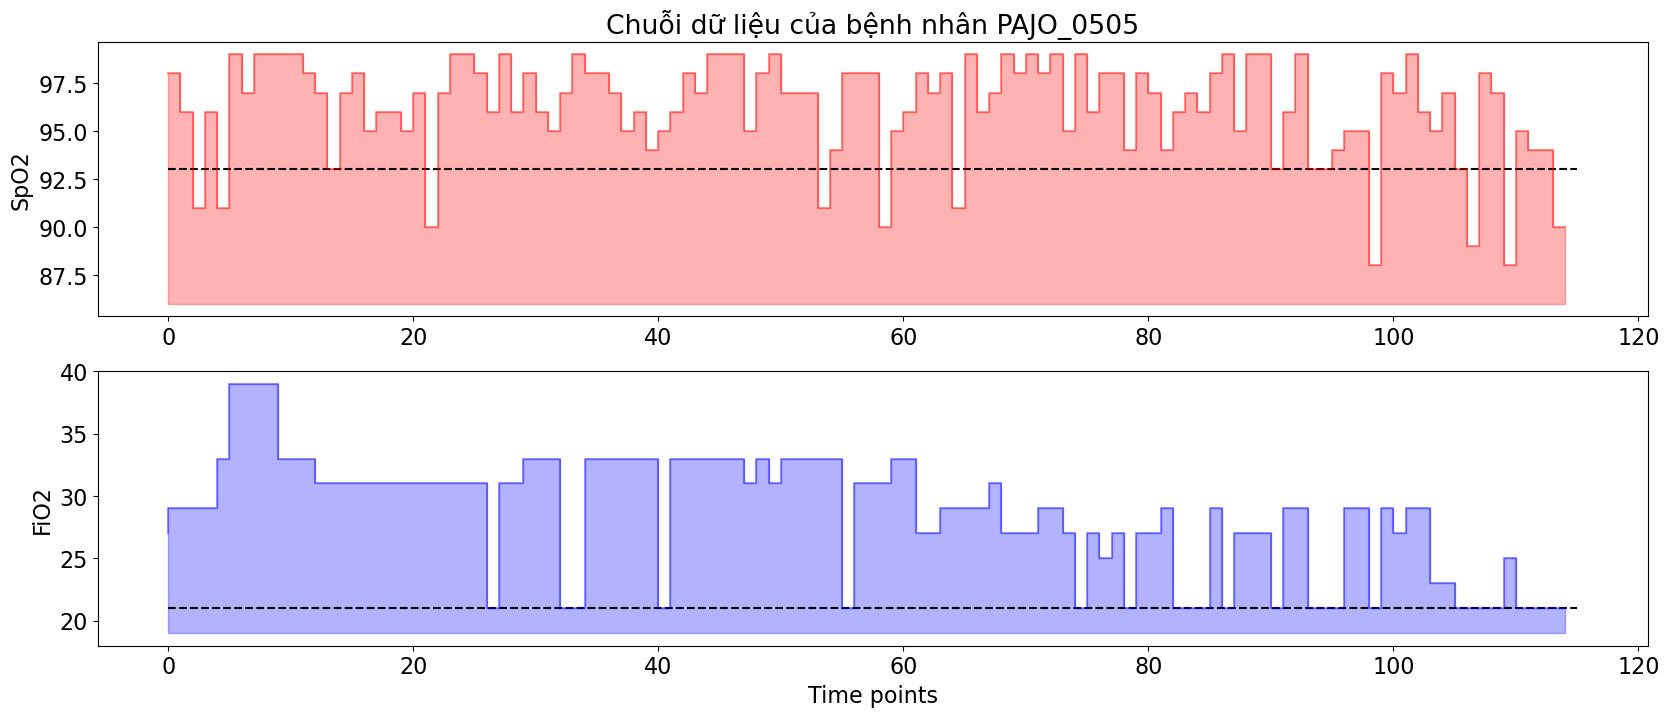

In [52]:
plot_sequence(seq_db, patient = 'PAJO_0505')

# Bước 3: Chọn số hidden states cho mô hình HMMG

Số hidden states là 1 tham số do người dùng chủ quan ấn định, Nhi viết 1 hàm để dựng nhiều mô hình HMMG với số hidden states từ 2 đến 12; và khảo sát trị số score của mỗi mô hình:

In [61]:
def hmmg_data_gen(seq_db = seq_db, add_noise = True):
    
    X1 = np.concatenate([seq_db[p]['FiO2'] for p in seq_db.keys()])
    X2 = np.concatenate([seq_db[p]['SpO2'] for p in seq_db.keys()])
    
    lengths = [len(seq_db[p]['SpO2']) for p in seq_db.keys()]
    
    X = np.column_stack([X1, X2])
    
    if add_noise:
        X = X + np.random.normal(0.5,0.5, size = (X1.shape[0],2))
        
    return X, lengths

In [62]:
X, lengths = hmmg_data_gen(seq_db, add_noise = True)

X

array([[32.97304749, 96.91682526],
       [34.25498359, 94.49077885],
       [32.76316863, 97.43579093],
       ...,
       [21.2832095 , 94.05054494],
       [20.87578077, 93.74674945],
       [20.73165974, 94.25341452]])

In [64]:
print(lengths)

[61, 22, 66, 14, 80, 76, 122, 108, 20, 10, 18, 99, 30, 58, 45, 47, 133, 93, 112, 16, 14, 44, 30, 71, 48, 58, 18, 80, 22, 29, 19, 111, 30, 22, 54, 40, 147, 43, 53, 67, 30, 19, 65, 34, 42, 51, 76, 77, 32, 22, 22, 107, 18, 56, 27, 37, 13, 24, 46, 115, 64, 48, 24, 22, 59, 31, 54, 118, 146, 47, 18, 26, 87, 17, 25, 51, 33, 141, 18, 53, 65]


In [70]:
def multi_hmmg(X = X, lengths = lengths, nmin = 2, nmax = 12, n_iter = 2000):
    
    n_components = np.arange(nmin, nmax)
    
    models1 = [GaussianHMM(n_components=n, 
                           covariance_type="diag",
                           n_iter = n_iter).fit(X, lengths)
               for n in n_components]
          
    models2 = [GaussianHMM(n_components=n, 
                           covariance_type="full",
                           n_iter = n_iter).fit(X, lengths)
               for n in n_components]
    
    plt.figure(figsize=(10,6))
    
    plt.plot(n_components, 
         [m.score_samples(X, lengths)[0] for m in models1], label='Diag covariance',
         c = 'red')
    
    plt.plot(n_components, 
         [m.score_samples(X, lengths)[0] for m in models2], label='Full covariance',
         c = 'blue')
    
    plt.legend(loc='best')
    plt.xlabel('n_components')
    plt.ylabel("Model's score")

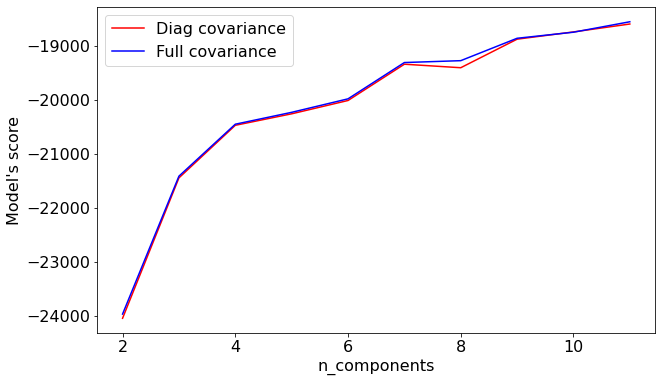

In [71]:
multi_hmmg(X = X, lengths = lengths, nmin = 2, nmax = 12, n_iter = 2000)

Nhi quyết định sẽ dựng mô hình cho 5 hidden states

# Bước 4: Dựng mô hình

Nhi dùng method GaussianHMM của thư viện hmmlearn, với algorithm là Viterbi để huấn luyện một mô hình HMMG với đầu ra là 1 phân phối hỗn hợp cho 2 biến, hay Gaussian Mixture; việc huấn luyện thực hiện trên nhiều đơn vị quan sát (chuỗi) với độ dài khác nhau.

Lưu ý dữ liệu đầu vào X là 1 array 2 chiều, mỗi hàng là 1 thời điểm, 2 cột là 2 biến FiO2, SpO2; và cần 1 array lengths chứa độ dài của từng chuỗi (ta đã có ở trên).

In [72]:
nc = 5

model = GaussianHMM(n_components=nc, 
                covariance_type="full",
                n_iter=5000)

model.fit(X, lengths)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=5, n_iter=5000, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

# Bước 5: Khai thác mô hình

## Mô tả 5 hidden states

Như lần trước, sau khi có mô hình, việc đầu tiên Nhi muốn làm là mô tả đặc tính phân bố của 5 trạng thái ẩn mà mô hình học được từ dữ liệu: 

Khác với bài trước, mỗi trạng thái ẩn là 1 Gaussian mixture distribution cho đồng thời 2 biến FiO2, SpO2; được xác định bằng 2 trung bình cho riêng FiO2, SpO2, và 1 covariance matrix 2x2. Đường chéo của covariance matrix cho phép ta suy ra độ lệch chuẩn (sigma) cho mỗi biến

In [237]:
def summary_hmmg(model):
    print("Mô tả các trạng thái ẩn")
    print('-'*40)
    for i in range(model.n_components):
        print(f'Trạng thái ẩn thứ {i+1}')
        print(f'FiO2: {float(model.means_[i][0])} ± {float(np.diag(model.covars_[i])[0]**0.5)}')
        print(f'SpO2: {float(model.means_[i][1])} ± {float(np.diag(model.covars_[i])[1]**0.5)}')
        print('-'*40)

In [238]:
summary_hmmg(model)

Mô tả các trạng thái ẩn
----------------------------------------
Trạng thái ẩn thứ 1
FiO2: 21.52215671833608 ± 0.44904375993556117
SpO2: 97.14092153523823 ± 2.1035997540279774
----------------------------------------
Trạng thái ẩn thứ 2
FiO2: 34.98851333609403 ± 1.5294842927706545
SpO2: 96.19954244695613 ± 2.13537400219952
----------------------------------------
Trạng thái ẩn thứ 3
FiO2: 21.064011478873784 ± 0.5713996804352666
SpO2: 89.95437453228524 ± 4.695564639109218
----------------------------------------
Trạng thái ẩn thứ 4
FiO2: 37.00357837544299 ± 1.6791618000661164
SpO2: 91.29772883895588 ± 4.713866983437132
----------------------------------------
Trạng thái ẩn thứ 5
FiO2: 28.982391616680147 ± 2.2203411662327985
SpO2: 95.79123736023334 ± 2.4688856133220147
----------------------------------------


## Ma trận chuyển tiếp giữa các hidden states

Tiếp theo, ta trích xuất ma trận xác suất chuyển tiếp giữa 5 hidden states, và đặt cho mỗi trạng thái 1 cái tên ngắn gọn, chính là trung bình của FiO2/SpO2

In [109]:
hidden_states = [f'{int(i[0])}/{int(i[1])}' for i in np.round(model.means_,0)-0.1]

tm_df = pd.DataFrame(model.transmat_, 
                     columns=hidden_states,
                     index=hidden_states)

tm_df

,35/93,26/95,50/82,21/95,29/89
35/93,0.906045,0.040889,2.449522e-14,1.132815e-02,0.041738
26/95,0.015891,0.883784,1.816208e-56,8.955132e-02,0.010774
50/82,0.010205,0.006439,9.671930e-01,6.400857e-03,0.009762
21/95,0.004718,0.078372,7.156649e-04,9.120490e-01,0.004145
29/89,0.121801,0.047608,3.391073e-02,4.439016e-15,0.796681


Từ ma trận xác suất chuyển tiếp, ta có thể dễ dàng vẽ biểu đồ heatmap

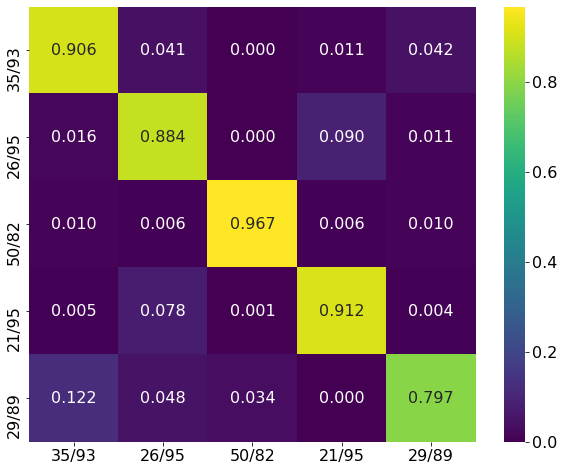

In [110]:
plt.rcParams['figure.figsize'] = (10,8)

sns.heatmap(tm_df, 
            cmap = 'viridis', 
            annot=True, 
            fmt=".3f")

Ta cũng có thể biểu diễn ma trận này bằng sơ đồ định hướng (directed graph):

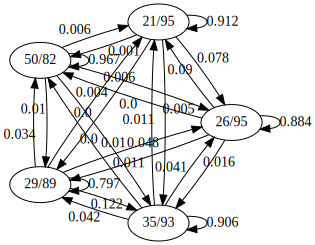

In [111]:
states = [str(i) for i in tm_df.index]

def get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = get_markov_edges(tm_df)

# create graph object
G = nx.DiGraph()

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label= np.round(v,3))
    
pos = nx.spring_layout(G)

edge_labels = {(n1,n2):np.round(d['label'],3) for n1,n2,d in G.edges(data=True)}

nx.drawing.nx_pydot.write_dot(G, "tmat.dot")

s = Source.from_file('tmat.dot', engine = 'circo') 

s

Lưu ý: ma trận chuyển tiếp cho ta biết xác suất chuyển tiếp từ 1 trạng thái này sang 1 trạng thái khác, mỗi trạng thái được đặc trưng bằng 2 giá trị trung bình của FiO2 và SpO2; kết hợp cả 2 lại với nhau sẽ cho ta biết ý nghĩa lâm sàng:

FiO2 có 5 mức : 21 tương đương với không áp dụng Oxy trị liệu; 26 tương ứng với việc hít Oxy với lưu lượng thấp đến trung bình; 35 tương ứng với lưu lượng Oxy cao, và 50 là lưu lượng Oxy rất cao.

SpO2 = 95% là giá trị bình thường, SpO2 = 93% trở xuống đánh dấu sự xuất hiện của mất bão hòa oxy máu, hay suy hô hấp; SpO2 thấp hơn 90% là suy hô hấp rất nặng, bệnh nhân đang ở trong tình trạng nguy kịch và có thể tử vong.

Ta thấy ở 1 số bệnh nhân, dù có tăng FiO2 thì cũng chưa chắc có thể kéo SpO2 về mức an toàn, SpO2 vẫn thấp hơn 90% (50/82, 29/89) (Trên thực tế các bệnh nhân này sau đó đều đã tử vong vì suy hô hấp.).

## Khảo sát trực quan hidden states trên quần thể 

Nhi viết 1 hàm cho phép vẽ những hình ellipse để định vị hidden states trên không gian dữ liệu 2 chiều tạo ra bởi SpO2 và FiO2. 

Đây là dạng biều đồ quen thuộc trong bài toán phân cụm bằng K-means hay Gaussian Mixture model. Như vậy kết quả của mô hình Hidden Markov Gaussian mixture có thể xem là tương đương với bài toán phân cụm bằng mô hình Gaussian mixture; tuy nhiên khác biệt ở chỗ: các quan sát trong dữ liệu mô hình Gaussian mixture là độc lập; còn quan sát trong dữ liệu mô hình HMMG là các thời điểm nối tiếp nhau, có yếu tố thời gian.

In [158]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_hmmg(gmm, X, label=True, ax=None, pal = 'Set2'):
    
    plt.rcParams.update({'font.size': 18})
    
    colors = cm.get_cmap(pal, gmm.n_components)
    cs = []
    
    for i in range(colors.N):
        rgb = colors(i)[:3] # will return rgba, we take only first 3 so we get rgb
        cs.append(matplotlib.colors.rgb2hex(rgb))
    
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=30, cmap = pal, zorder=1, alpha = 0.3)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=30, zorder=1, alpha = 0.1)
    ax.axis('equal')
        
    # for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    #    draw_ellipse(pos, covar, alpha=w * w_factor, color = 'red')
    
    n_comps = [i for i in range(gmm.n_components)]
    
    for i, pos, covar in zip(n_comps, gmm.means_, gmm.covars_):
        draw_ellipse(pos, covar, alpha= 0.35, color = cs[i], zorder = 2)
        
    ax.scatter(gmm.means_[:,0], gmm.means_[:, 1], s=100, zorder=3, color ='black')
    sns.regplot(gmm.means_[:,0], gmm.means_[:, 1], lowess=True, line_kws={'color':'black',})
    ax.set_xlim(20,76)
    ax.set_ylim(49,101)

Text(0, 0.5, 'SpO2')

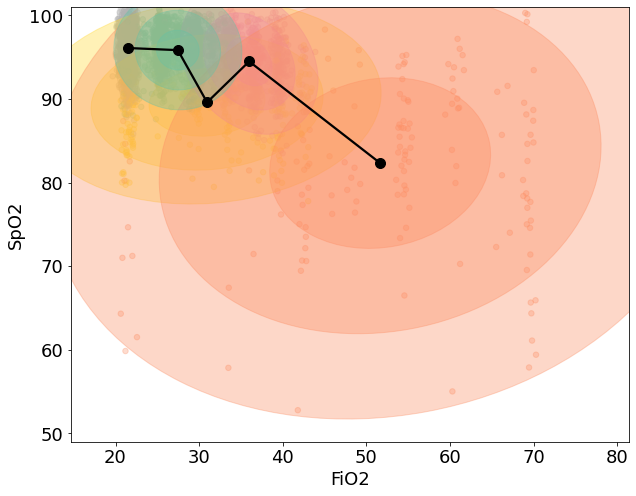

In [170]:
plot_hmmg(model, X, pal = 'Set2_r')

plt.xlabel('FiO2')
plt.ylabel('SpO2')

Trên biểu đồ này, mỗi điểm tròn nhỏ là 1 đơn vị quan sát trong toàn bộ dữ liệu (81 chuỗi, tổng cộng hơn 4000 data points); 

Mỗi hình elip được tô màu khác nhau là 1 hidden state, tâm mỗi elipse (điểm tròn đen) là giá trị trung bình của SpO2 và FiO2.

#  Áp dụng mô hình cho cá thể

Ngoài ứng dụng suy diễn tổng quát, mô hình HMM còn có thể dùng để tiên lượng cho từng cá thể (còn gọi là decode), cho dữ liệu quan sát mô hình sẽ xuất ra trạng thái ẩn và xác suất của mỗi trạng thái;

Nhi viết 1 hàm để tạo dữ liệu cá thể để dùng cho mô hình:

In [139]:
def hmmg_idv_data_gen(seq_db = seq_db, p=None,add_noise = True):
    
    X1 = np.concatenate([seq_db[p]['FiO2']])
    X2 = np.concatenate([seq_db[p]['SpO2']])
    
    X = np.column_stack([X1, X2])
    
    if add_noise:
        X = X + np.random.normal(0.5,0.5, size = (X1.shape[0],2))
    
    return X

x_roma = hmmg_idv_data_gen(seq_db, 'ROMA_1904', True)

## Chuyển chuỗi dữ liệu quan sát thành trạng thái ẩn

Việc này giống như ta đang phân cụm dữ liệu chuỗi thời gian, mô hình HMMG gán cho mỗi giá trị một label là tên hidden state (ta có 5 labels)

Thí dụ trên 1 bệnh nhân:

In [149]:
decodes = model.decode(x_roma)

decodes

(-638.2267728482404,
 array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 4, 4,
        4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

## Chuyển dữ liệu thành xác suất của mỗi trạng thái

Ngoài chức năng dán label, mô hình còn có thể ước tính xác suất cho 5 hidden states tại mỗi thời điểm:

Text(0, 0.5, 'Predicted probs')

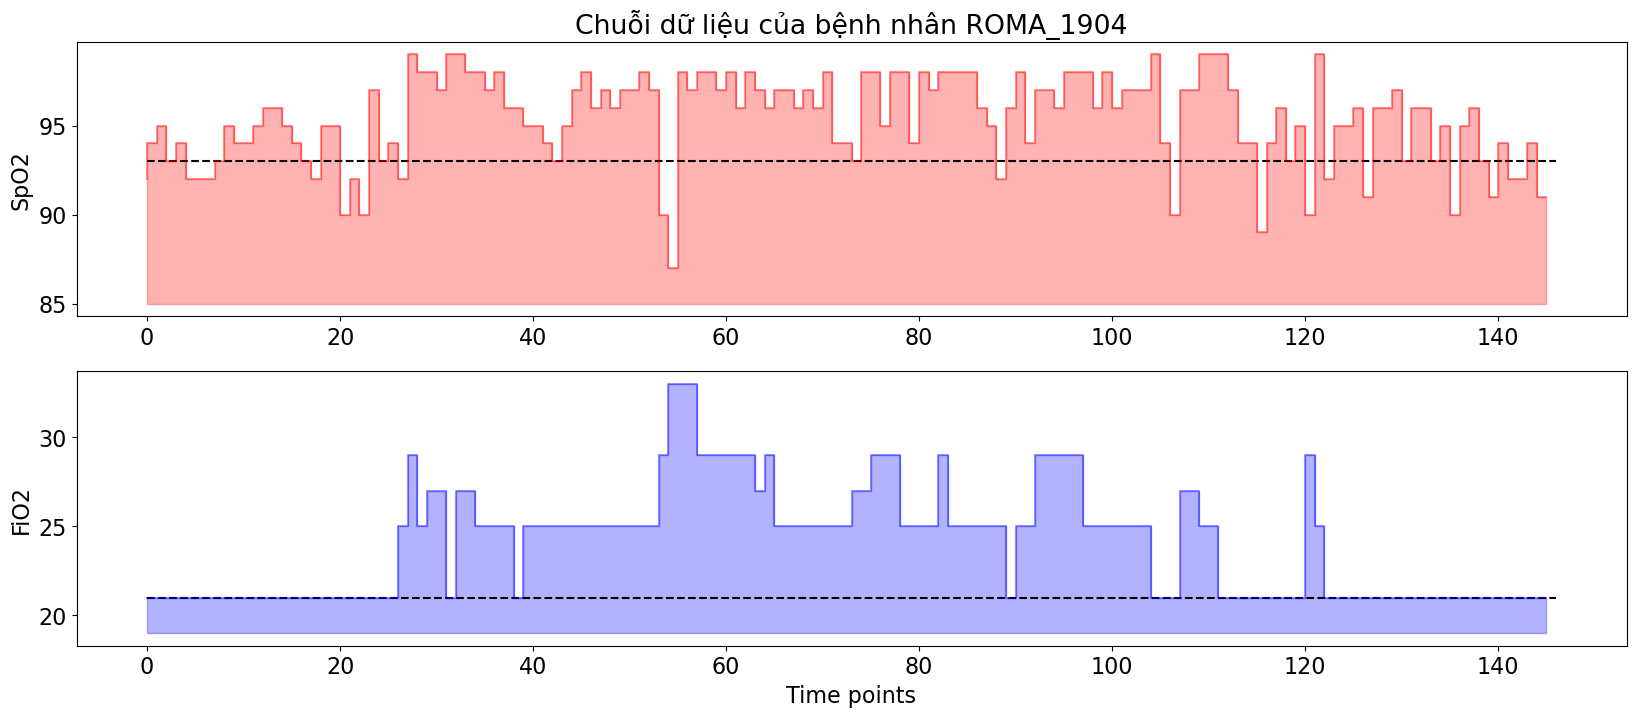

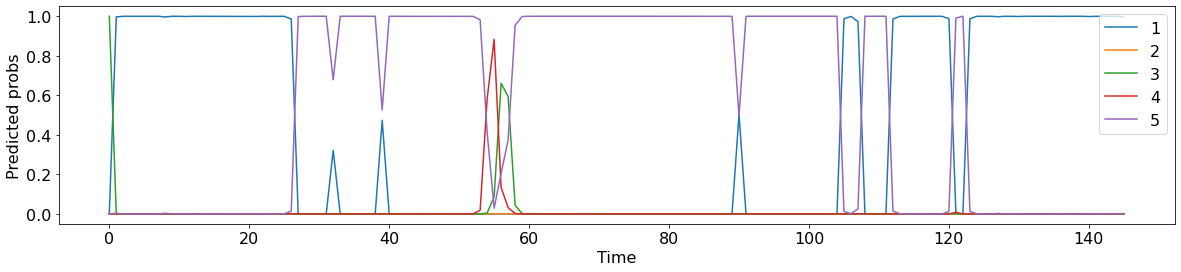

In [155]:
plot_sequence(seq_db, patient = 'ROMA_1904')

plt.figure(figsize=(20,4))

for i,s in enumerate(pred_prob):
    plt.plot(s, label =str(i+1))
    
plt.legend(loc = 'upper right')
plt.xlabel('Time')
plt.ylabel('Predicted probs')

## Khảo sát Joint probability cho cá thể

Ta có thể dùng biểu đồ ellipse ở trên cho dữ liệu của từng cá thể, để khảo sát đặc điểm của joint probability giữa FiO2 và SpO2 trong không gian 2 chiều:

In [144]:
pred_prob = np.round(model.predict_proba(x_roma),5).T

Text(0, 0.5, 'SpO2')

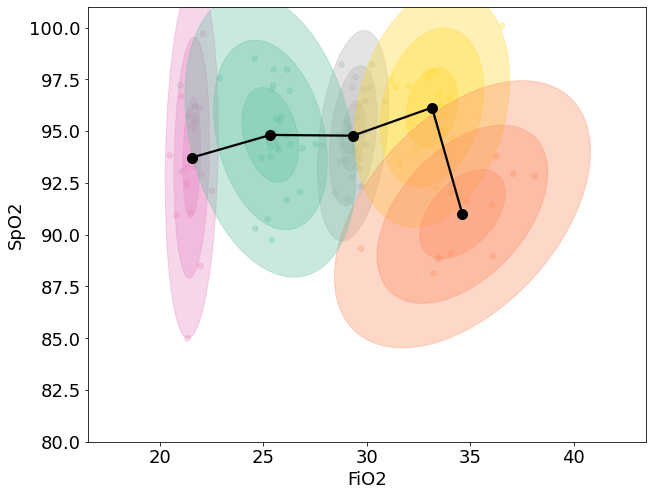

In [203]:
plot_hmmg(model, 
          hmmg_idv_data_gen(seq_db, 'ROGIO_2704', True),
          pal = 'Set2_r')

plt.xlim(20,40)
plt.ylim(80,101)
plt.xlabel('FiO2')
plt.ylabel('SpO2')

Text(0, 0.5, 'SpO2')

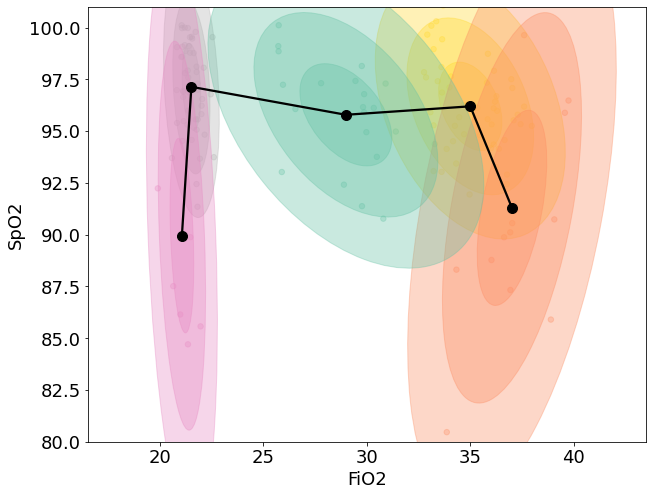

In [235]:
plot_hmmg(model, 
          hmmg_idv_data_gen(seq_db, 'TAMA_0505', True),
          pal = 'Set2_r')

plt.xlim(20,40)
plt.ylim(80,101)
plt.xlabel('FiO2')
plt.ylabel('SpO2')

Text(0, 0.5, 'SpO2')

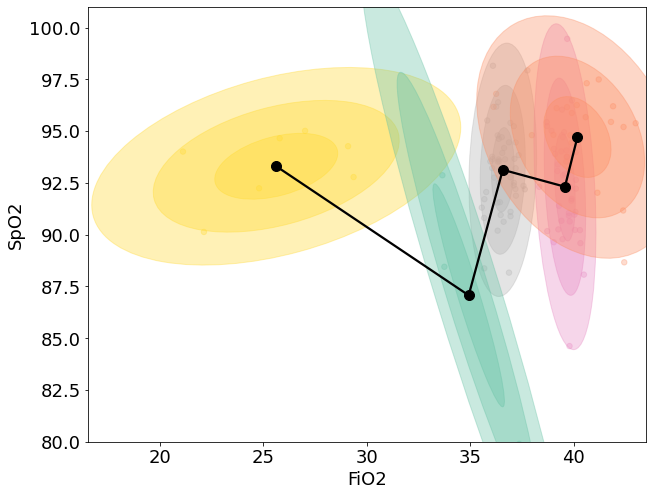

In [223]:
plot_hmmg(model, 
          hmmg_idv_data_gen(seq_db, 'CAJO_2104', True),
          pal = 'Set2_r')

plt.xlim(20,40)
plt.ylim(80,101)
plt.xlabel('FiO2')
plt.ylabel('SpO2')

# Kết luận

Thí nghiệm này là sự mở rộng ứng dụng của mô hình Markov ẩn cho phép khảo sát đồng thời 2 chuỗi dữ liệu; kết quả của mô hình rất gần với bài toán phân cụm bằng mô hình Gaussian Mixture hoặc K-means, nhưng Hidden Markov model thích hợp hơn cho dữ liệu time series.

Với dữ liệu thô, và từ chỗ chưa có giả thuyết nào; ta đã rút ra được nhiều thông tin có ý nghĩa về lâm sàng; thí dụ ta hình dung một bệnh nhân bị viêm phổi do Covid-19 có thể trải qua các trạng thái nào, liệu Oxy liệu pháp có hiệu quả trị liệu hay không khi SpO2 giảm đến mức báo động, và có bao nhiêu cơ hội là SpO2 có thể hồi phục từ giai đoạn nguy kịch ? Nếu hiện tại bệnh nhân vẫn hô hấp bình thường thì có bao nhiêu nguy cơ sẽ rơi vào tình trạng suy hô hấp ?...

Nhi cũng xin nói thêm là 1 số bệnh nhân trong dữ liệu này đã không thể qua khỏi và tử vong vì suy hô hấp. Những giá trị SpO2 giảm dưới 80%; thậm chí đến 50-60% chính là giai đoạn cận kề cái chết. Nhi và các bạn hãy dành một phút mặc niệm để nghĩ về những nạn nhân này, người thân của họ. Nhi muốn cảm tạ những thông điệp mà bệnh nhân để lại và công sức của các điều dưỡng viên đã ghi chép dữ liệu để ta có thể học tập trên dữ liệu này.

Ghi chú: Vì lý do bảo mật, Nhi không chia sẻ dữ liệu, nhưng với nội dung code và cấu trúc dataframe, các bạn có thể dễ dàng tái lập thí nghiệm với dữ liệu mô phỏng hoặc bài toán tương tự.